### 2023/10/8 

## 1 初步验证：开盘到十二点量价数据与十二点到三点或十二点到四点价格波动间的关联
### 1.1 思路
### 验证开盘到十二点量价数据与十二点到三点或十二点到四点价格波动间的关联，为进一步构造跨式套利做准备。先利用SPY 进行初步测试，再推广到其他品种上。

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

### 1.2 数据预处理

In [2]:
data = pd.read_csv('SPY.csv')

data['Timestamp'] = pd.to_datetime(data['DateOrigin'] - 2, unit='D', origin=pd.Timestamp('1900-01-01')) + \
                    pd.to_timedelta(data['TimeOrigin'] * 24, unit='h')

data.set_index('Timestamp', inplace=True)

morning_data = data.between_time('09:30', '12:00')
afternoon_data = data.between_time('12:01', '16:00')

### 1.3 计算统计量

In [3]:
grouped_morning = morning_data.groupby(morning_data.index.date)
grouped_afternoon = afternoon_data.groupby(afternoon_data.index.date)

morning_vol = grouped_morning['Volume'].sum()
afternoon_low = grouped_afternoon['Low'].min()
afternoon_high = grouped_afternoon['High'].max()
afternoon_std = grouped_afternoon['Close'].std()
afternoon_std_full = afternoon_data.groupby(afternoon_data.index.date)['Close'].std()
morning_shift = morning_data['VWAP'].iloc[-1] - morning_data['Open'].iloc[0]
afternoon_shift = afternoon_data['Close'].iloc[-1] - afternoon_data['VWAP'].iloc[0]
morning_absVxD = (morning_data['Volume'] * morning_data['Close'].pct_change().abs()).sum()
noon_data = data[data.index.strftime('%H:%M:%S') == '12:00:00']
noon_vwap = noon_data['VWAP']

def calculate_shift(group, period):
    if period == 'morning':
        return abs(group['VWAP'].iloc[-1] - group['Open'].iloc[0])
    elif period == 'afternoon':
        return abs(group['Close'].iloc[-1] - group['VWAP'].iloc[0])

def calculate_shift1(group, period):
    if period == 'morning':
        return group['VWAP'].iloc[-1] - group['Open'].iloc[0]
    elif period == 'afternoon':
        return group['Close'].iloc[-1] - group['VWAP'].iloc[0]

def perform_regression_and_print_results(x, y, x_label, y_label):
    # Remove rows with NaN or infinite values in x or y
    mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)
    x = x[mask]
    y = y[mask]
    
    # Check if the length of x or y is zero
    if len(x) == 0 or len(y) == 0:
        print(f"Insufficient data for regression of {y_label} vs {x_label}.")
        return
    
    # Add a constant (i.e., bias or intercept) to the independent variable
    x = sm.add_constant(x)
    
    # Perform linear regression
    model = sm.OLS(y, x).fit()
    
    # Print out the statistics
    print(f"Regression results for {y_label} vs {x_label}:")
    print(model.summary())
    print("\n\n")


# 计算每天的morning_shift和afternoon_shift
morning_shift_per_day = grouped_morning.apply(calculate_shift, period='morning')
afternoon_shift_per_day = grouped_afternoon.apply(calculate_shift, period='afternoon')

morning_shift_per_day_noabs = grouped_morning.apply(calculate_shift1, period='morning')
afternoon_shift_per_day_noabs = grouped_afternoon.apply(calculate_shift1, period='afternoon')

#生成结果


results = pd.DataFrame({
    'Morning Volume': [morning_vol],
    'Afternoon Low': [afternoon_low],
    'Afternoon High': [afternoon_high],
    'Afternoon Std': [afternoon_std],
    'Full Afternoon Std': [afternoon_std_full],
    '12:00 VWAP': [noon_vwap],
    'Morning Shift': [morning_shift_per_day],
    'Afternoon Shift': [afternoon_shift_per_day],
    'absVxD': [morning_absVxD]
})
results.to_csv('result1.csv', index=False)

### 1.4 视图

### 1.4.1 结论1：尾盘放大效应显著，十二点到三点价格标准差小于十二点到四点

Regression results for 12:00 to 15:00 Std vs Full Afternoon Std:
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.372e+33
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        20:02:08   Log-Likelihood:                 47062.
No. Observations:                1398   AIC:                        -9.412e+04
Df Residuals:                    1396   BIC:                        -9.411e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

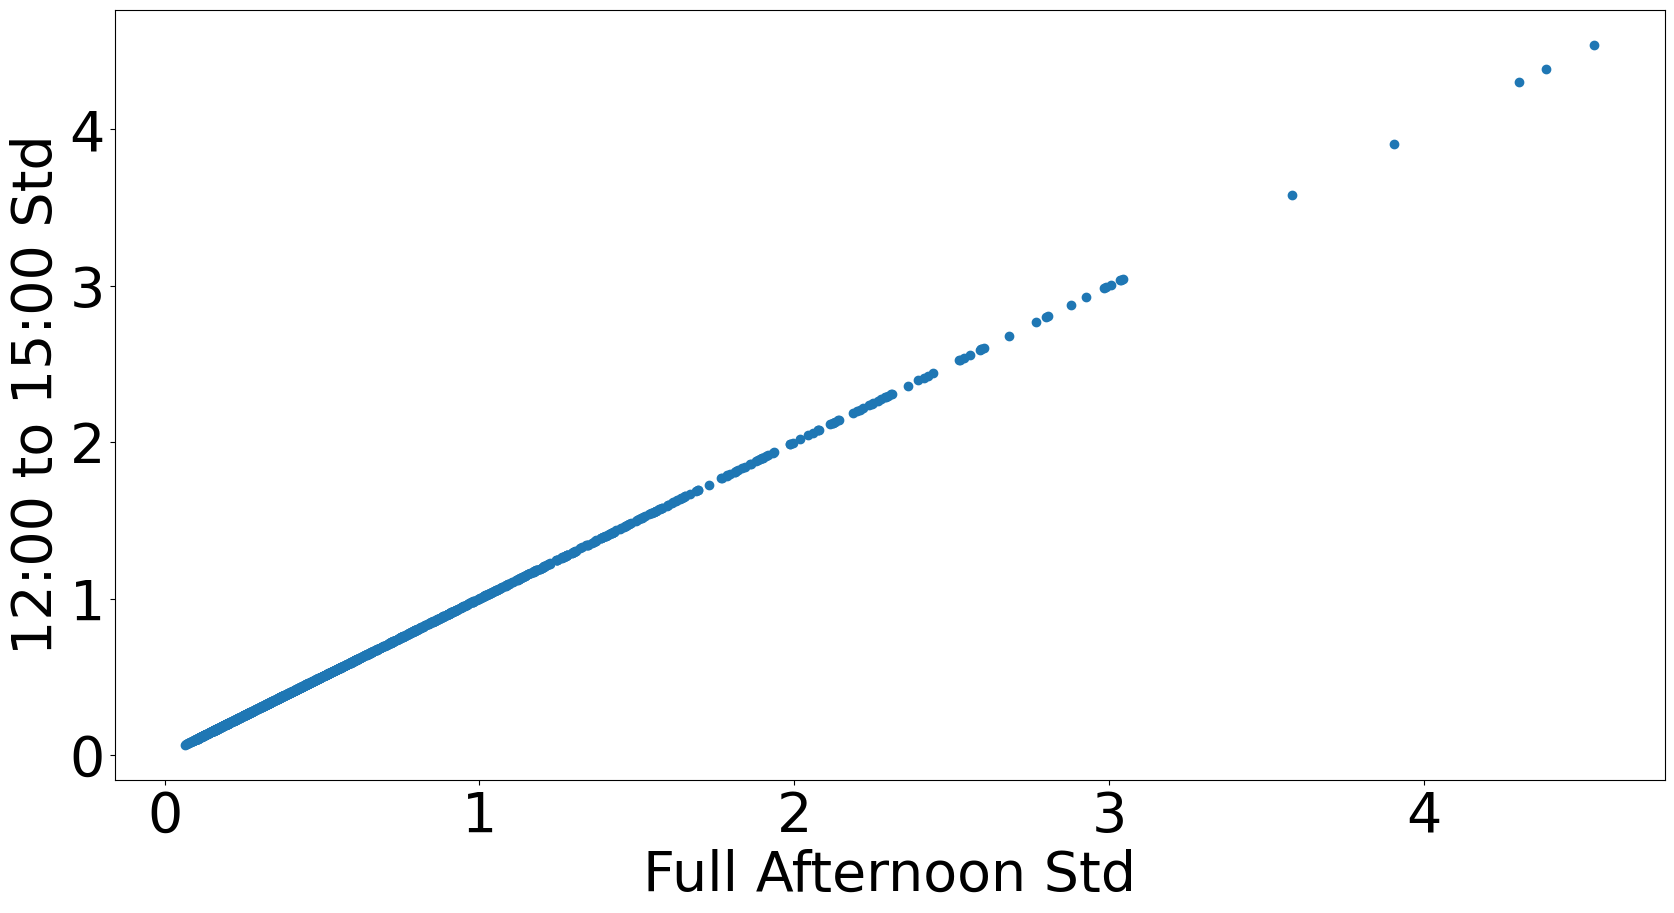

In [8]:
plt.rcParams['font.size']= 40
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.scatter(afternoon_std_full, afternoon_std)
axs.set_xlabel('Full Afternoon Std')
axs.set_ylabel('12:00 to 15:00 Std')
perform_regression_and_print_results(afternoon_std_full, afternoon_std, 'Full Afternoon Std', '12:00 to 15:00 Std')

### 1.4.2 结论2：上午成交量对下午价格 波动率预测意义不大

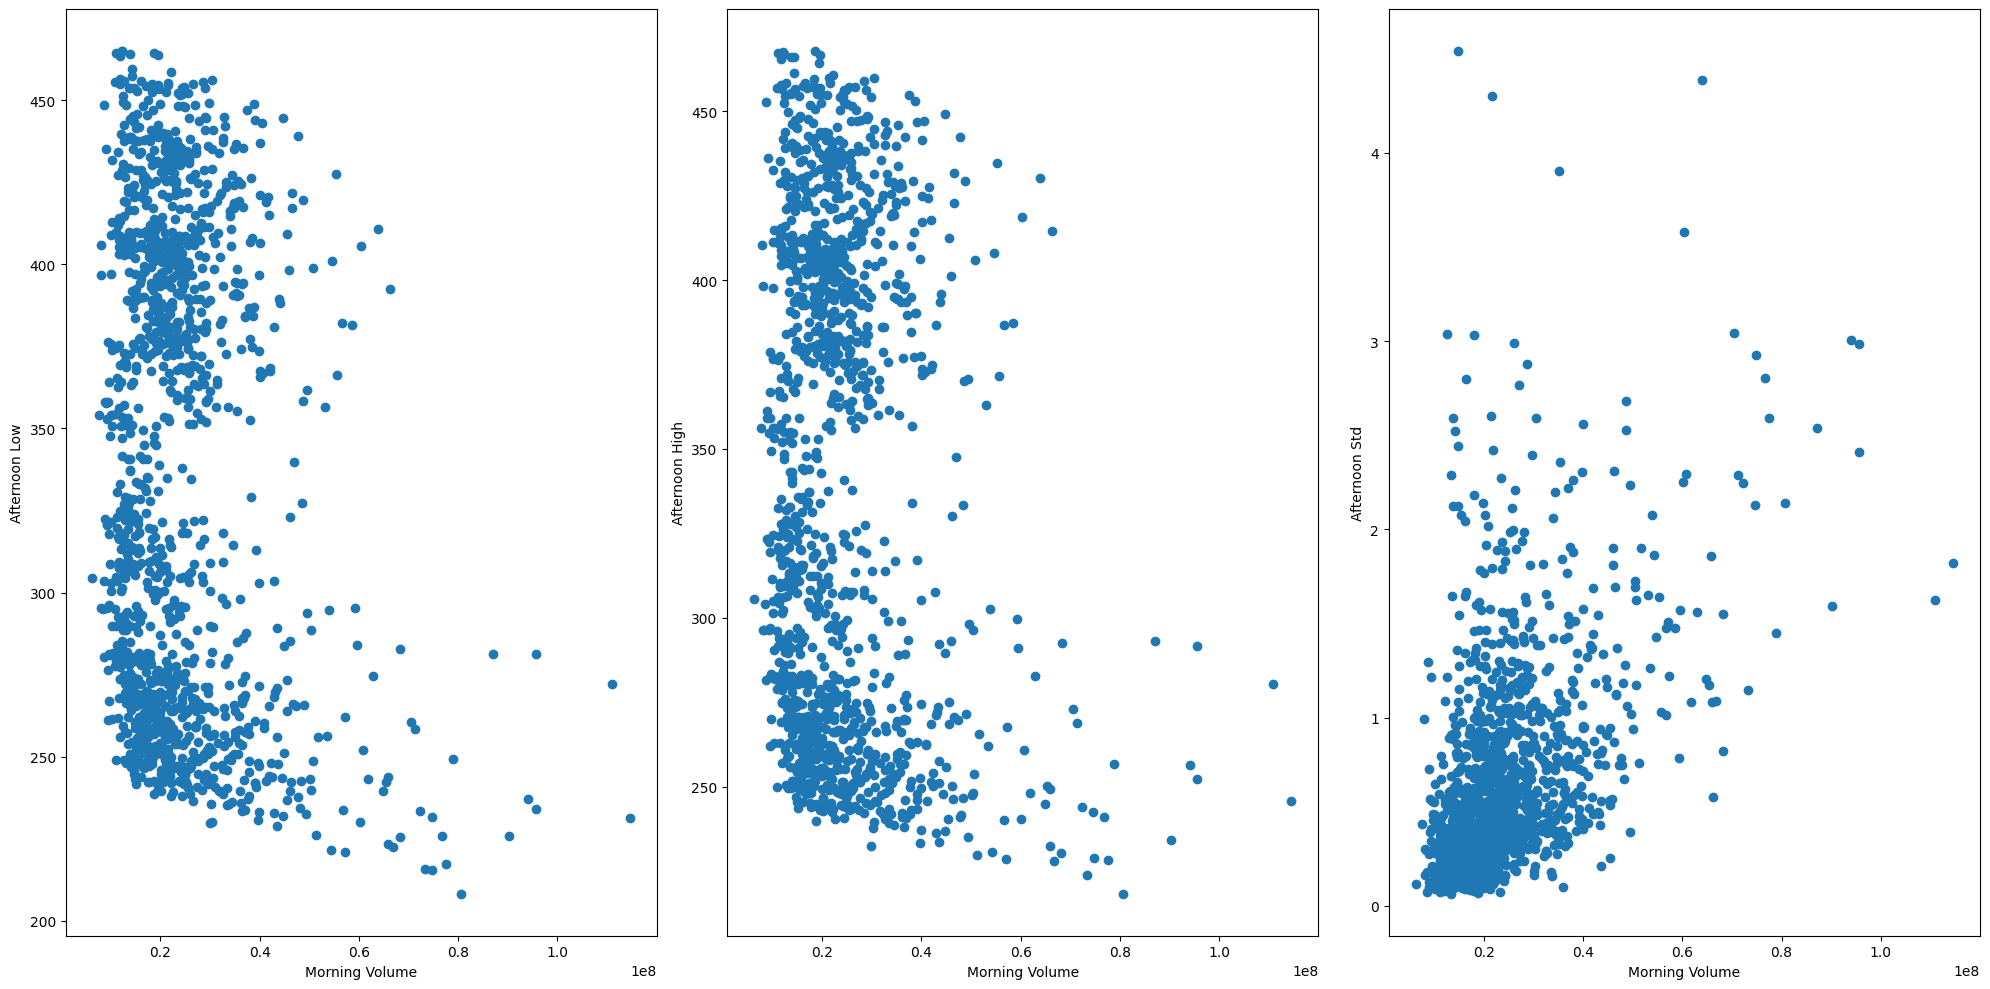

Regression results for Afternoon Low vs Morning Volume:
                            OLS Regression Results                            
Dep. Variable:                    Low   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     36.66
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           1.81e-09
Time:                        22:25:47   Log-Likelihood:                -7933.8
No. Observations:                1398   AIC:                         1.587e+04
Df Residuals:                    1396   BIC:                         1.588e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))


# 图 1
axs[0].scatter(morning_vol, afternoon_low)
axs[0].set_xlabel('Morning Volume')
axs[0].set_ylabel('Afternoon Low')

# 图 2
axs[1].scatter(morning_vol, afternoon_high)
axs[1].set_xlabel('Morning Volume')
axs[1].set_ylabel('Afternoon High')

# 图 3
axs[2].scatter(morning_vol, afternoon_std)
axs[2].set_xlabel('Morning Volume')
axs[2].set_ylabel('Afternoon Std')

plt.tight_layout()
plt.show()
perform_regression_and_print_results(morning_vol, afternoon_low, 'Morning Volume', 'Afternoon Low')
perform_regression_and_print_results(morning_vol, afternoon_high, 'Morning Volume', 'Afternoon High')
perform_regression_and_print_results(morning_vol, afternoon_std, 'Morning Volume', 'Afternoon Std')

### 1.4.3 结论3 上午VWAP中位数与下午最高价、最低价相关

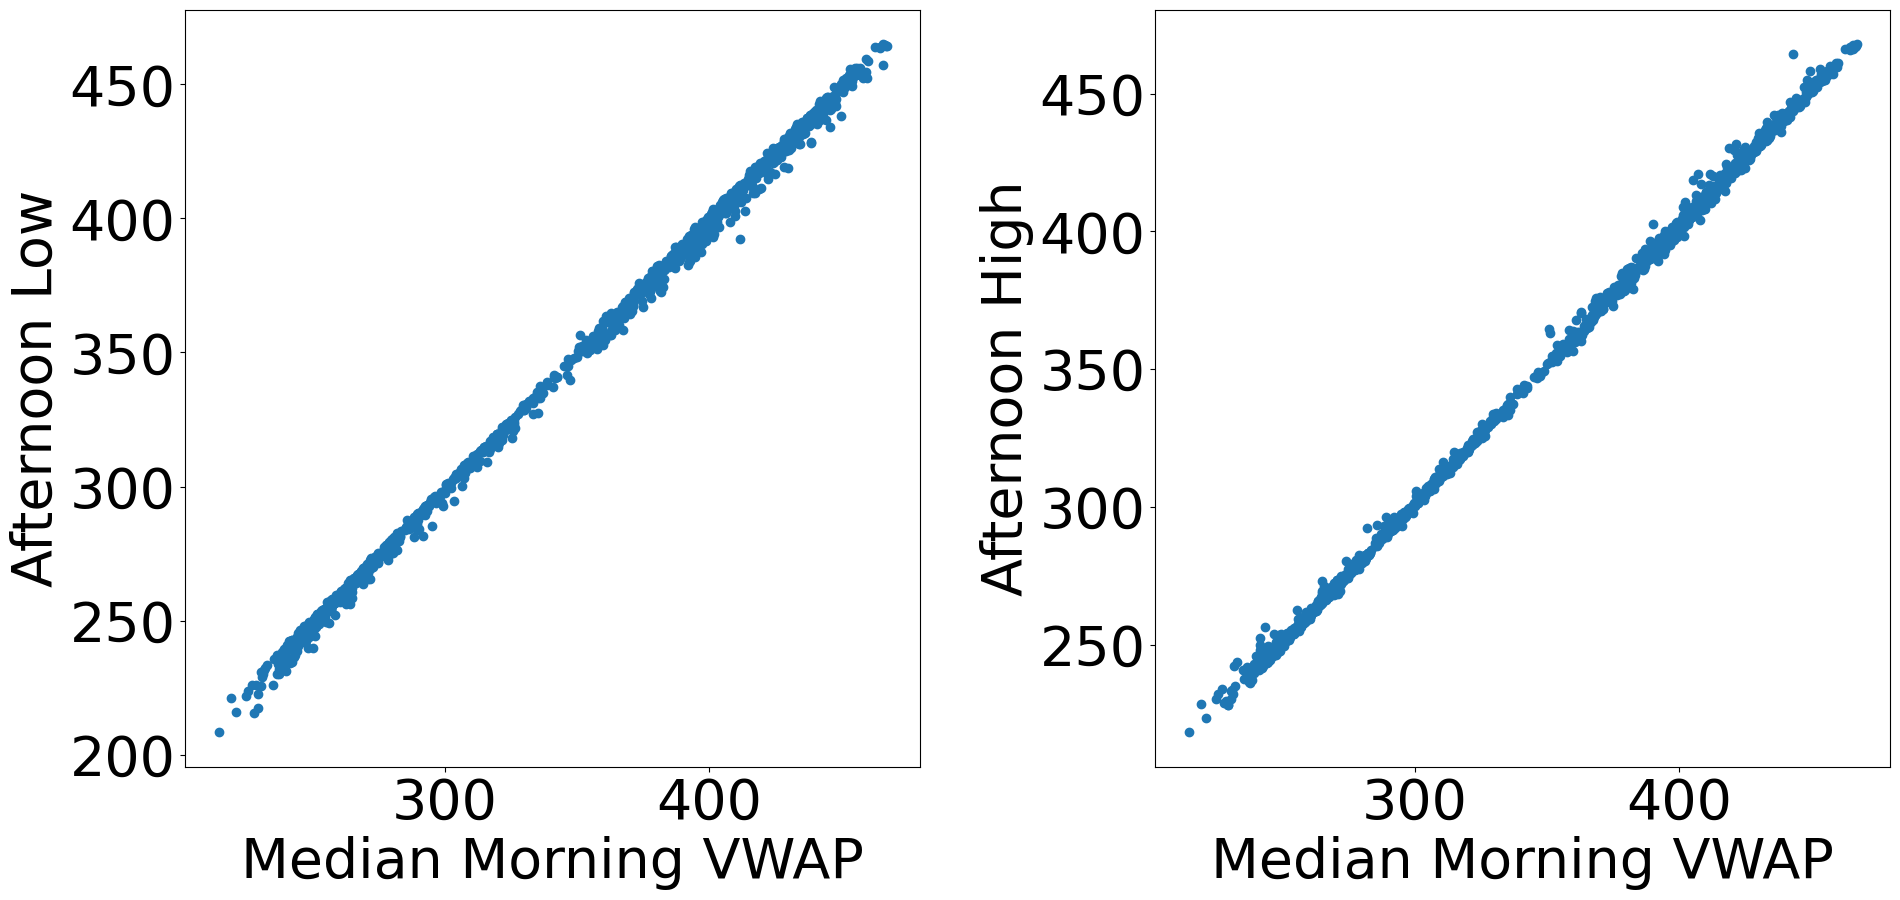

Insufficient data for regression of Afternoon Low vs Median Morning VWAP.
Insufficient data for regression of Afternoon High vs Median Morning VWAP.


In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
plt.rcParams['font.size']= 40
# 图 1
axs[0].scatter(noon_vwap, afternoon_low)
axs[0].set_xlabel('Median Morning VWAP')
axs[0].set_ylabel('Afternoon Low')

# 图 2
axs[1].scatter(noon_vwap, afternoon_high)
axs[1].set_xlabel('Median Morning VWAP')
axs[1].set_ylabel('Afternoon High')

plt.tight_layout()
plt.show()
perform_regression_and_print_results(noon_vwap, afternoon_low, 'Median Morning VWAP', 'Afternoon Low')
perform_regression_and_print_results(noon_vwap, afternoon_high, 'Median Morning VWAP', 'Afternoon High')




## 2 验证实时跟踪下午时段成交量变化

### 2.1 利用价格位移（收盘 中午）作为因变量验证

### 2.1.1 结论4：上午成交量与下午价格位移绝对值有关

Regression results for Afternoon Shift vs Morning Shift:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     310.4
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           6.99e-63
Time:                        22:25:48   Log-Likelihood:                -2799.4
No. Observations:                1398   AIC:                             5603.
Df Residuals:                    1396   BIC:                             5613.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

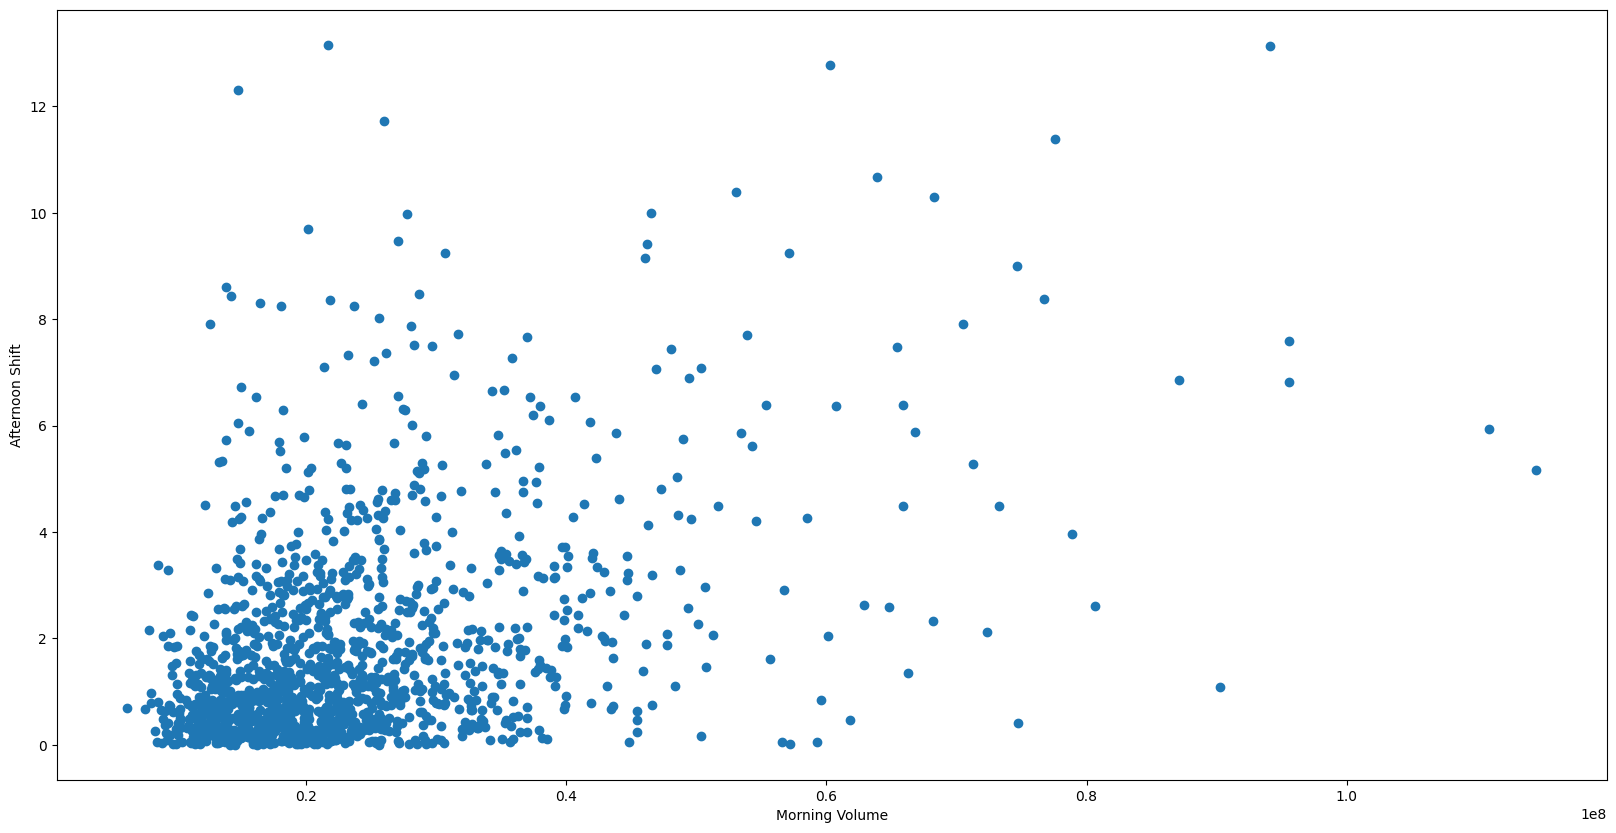

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.scatter(morning_vol, afternoon_shift_per_day)
axs.set_xlabel('Morning Volume')
axs.set_ylabel('Afternoon Shift')
perform_regression_and_print_results(morning_vol, afternoon_shift_per_day, 'Morning Shift', 'Afternoon Shift')

### 2.1.2 结论5：上午和下午位移并没有显著关系

Regression results for Afternoon Shift vs Morning Shift:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     73.99
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           2.07e-17
Time:                        22:25:48   Log-Likelihood:                -3333.0
No. Observations:                1398   AIC:                             6670.
Df Residuals:                    1396   BIC:                             6681.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

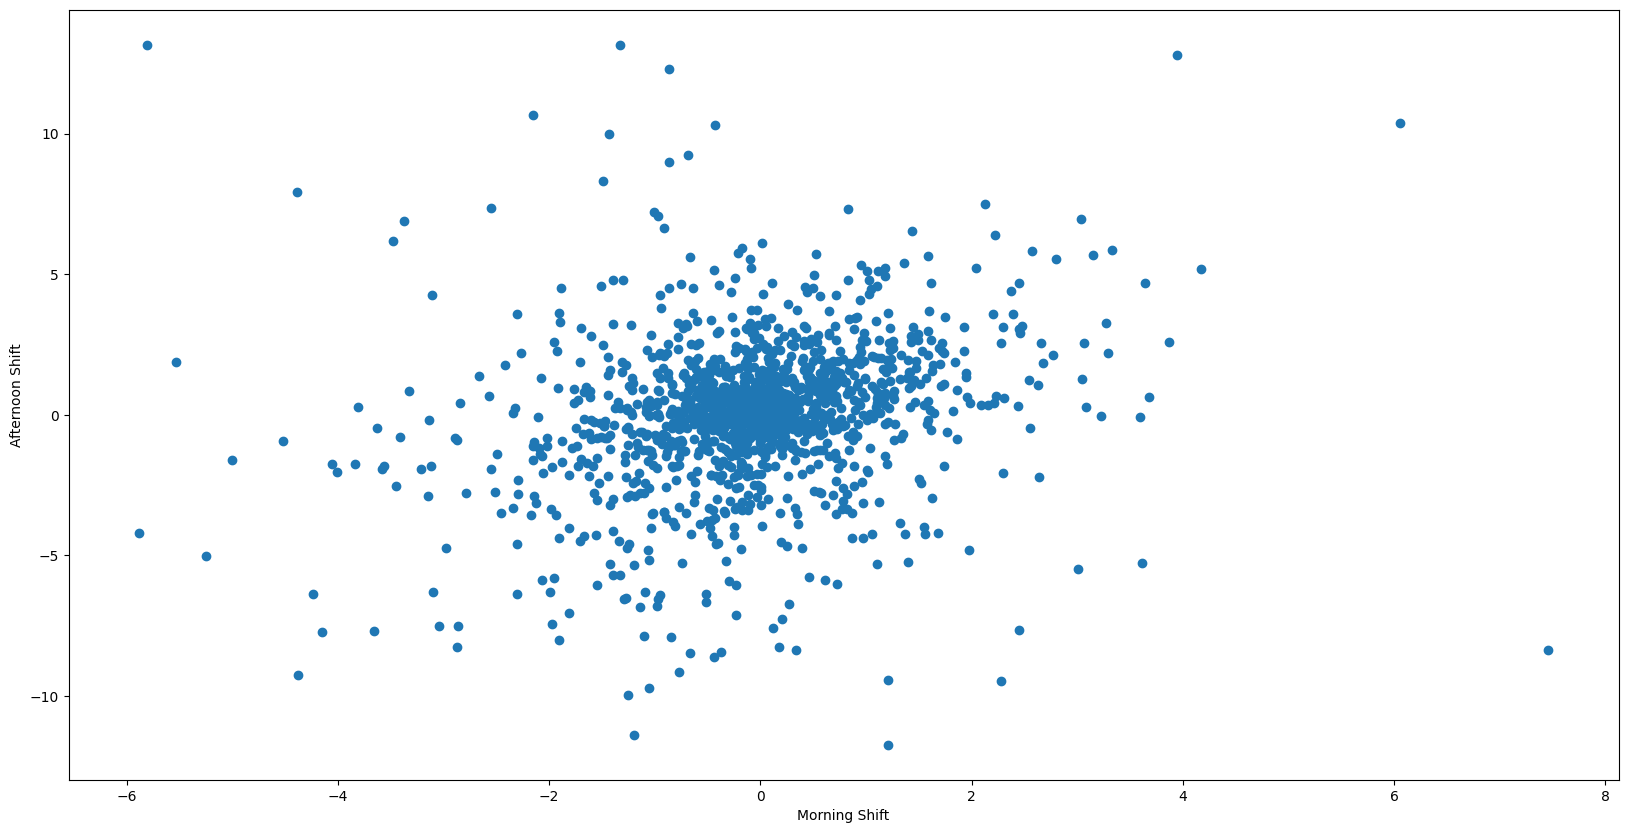

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.scatter(morning_shift_per_day_noabs, afternoon_shift_per_day_noabs)
axs.set_xlabel('Morning Shift')
axs.set_ylabel('Afternoon Shift')
perform_regression_and_print_results(morning_shift_per_day_noabs, afternoon_shift_per_day_noabs, 'Morning Shift', 'Afternoon Shift')

## 3 控制绝对价格的影响

### 3.1 初步验证：开盘到十二点量价数据与十二点到三点或十二点到四点价格波动间的关联

In [9]:
# 重新计算统计量
afternoon_low1 = (grouped_afternoon['Low'].min() - grouped_afternoon['Low'].min().shift(1)) / grouped_afternoon['Low'].min().shift(1) 
afternoon_high1 = (grouped_afternoon['High'].max() - grouped_afternoon['High'].max().shift(1)) / grouped_afternoon['High'].max().shift(1) 
afternoon_std1 = (grouped_afternoon['Close'].std() - grouped_afternoon['Close'].std().shift(1)) / grouped_afternoon['Close'].std().shift(1) 
afternoon_std_full1 = (afternoon_data.groupby(afternoon_data.index.date)['Close'].std() - afternoon_data.groupby(afternoon_data.index.date)['Close'].std().shift(1)) / afternoon_data.groupby(afternoon_data.index.date)['Close'].std().shift(1) 
noon_vwap1 = (noon_data['VWAP'] - noon_data['VWAP'].shift(1)) / noon_data['VWAP'].shift(1) 



morning_shift_per_day1 = (grouped_morning.apply(calculate_shift, period='morning') - grouped_morning.apply(calculate_shift, period='morning').shift(1)) / grouped_morning.apply(calculate_shift, period='morning').shift(1) 
afternoon_shift_per_day1 = (grouped_afternoon.apply(calculate_shift, period='afternoon') - grouped_afternoon.apply(calculate_shift, period='afternoon').shift(1)) / grouped_afternoon.apply(calculate_shift, period='afternoon').shift(1) 


morning_shift_per_day_noabs1 = (grouped_morning.apply(calculate_shift1, period='morning') - grouped_morning.apply(calculate_shift1, period='morning').shift(1)) / grouped_morning.apply(calculate_shift1, period='morning').shift(1) 
afternoon_shift_per_day_noabs1 = (grouped_afternoon.apply(calculate_shift1, period='afternoon') - grouped_afternoon.apply(calculate_shift1, period='afternoon').shift(1)) / grouped_afternoon.apply(calculate_shift1, period='afternoon').shift(1) 

results1 = pd.DataFrame({
    'Morning Volume': morning_vol,
    'Afternoon Low': afternoon_low1,
    'Afternoon High': afternoon_high1,
    'Afternoon Std': afternoon_std1,
    'Full Afternoon Std': afternoon_std_full1,
    '12:00 VWAP': noon_vwap1,
    'Morning Shift': morning_shift_per_day1,
    'Afternoon Shift': afternoon_shift_per_day1
})

C:\Users\52595\AppData\Local\Temp\ipykernel_17732\2376649144.py:17: RuntimeWarning: Cannot compare Timestamp with datetime.date. Use ts == pd.Timestamp(date) or ts.date() == date instead., sort order is undefined for incomparable objects.
  results1 = pd.DataFrame({


### 3.1.1 结论1不变：尾盘放大效应显著，十二点到三点价格标准差小于十二点到四点 

Regression results for 12:00 to 15:00 Std vs Full Afternoon Std:
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.312e+32
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        22:25:52   Log-Likelihood:                 45710.
No. Observations:                1397   AIC:                        -9.142e+04
Df Residuals:                    1395   BIC:                        -9.141e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

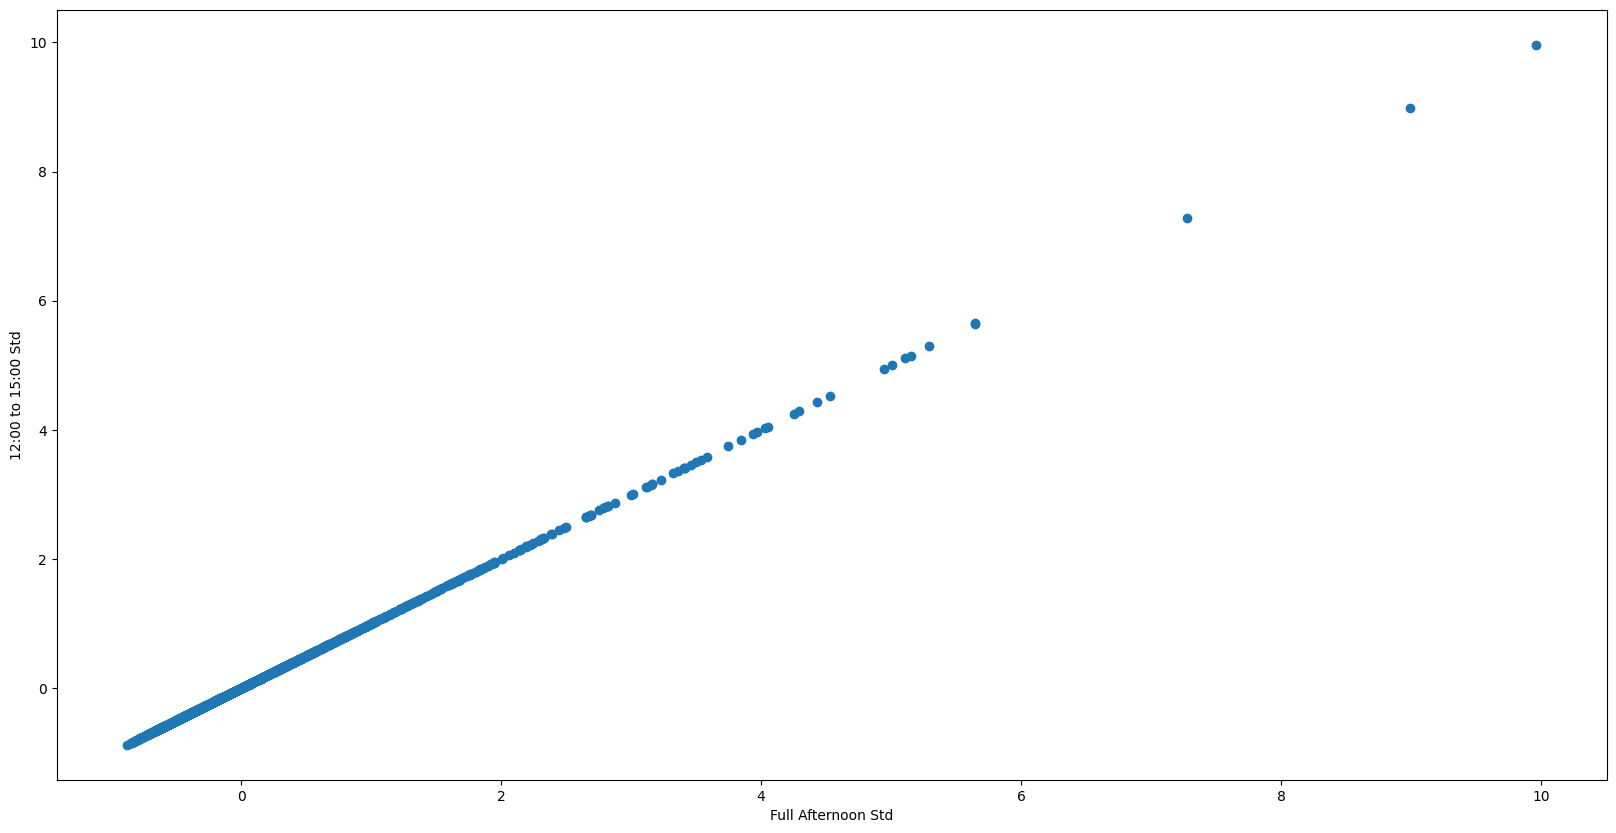

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.scatter(afternoon_std_full1, afternoon_std1)
axs.set_xlabel('Full Afternoon Std')
axs.set_ylabel('12:00 to 15:00 Std')
perform_regression_and_print_results(afternoon_std_full1, afternoon_std1, 'Full Afternoon Std', '12:00 to 15:00 Std')

### 3.1.2 结论2不变：上午成交量对下午价格 波动率预测意义不大

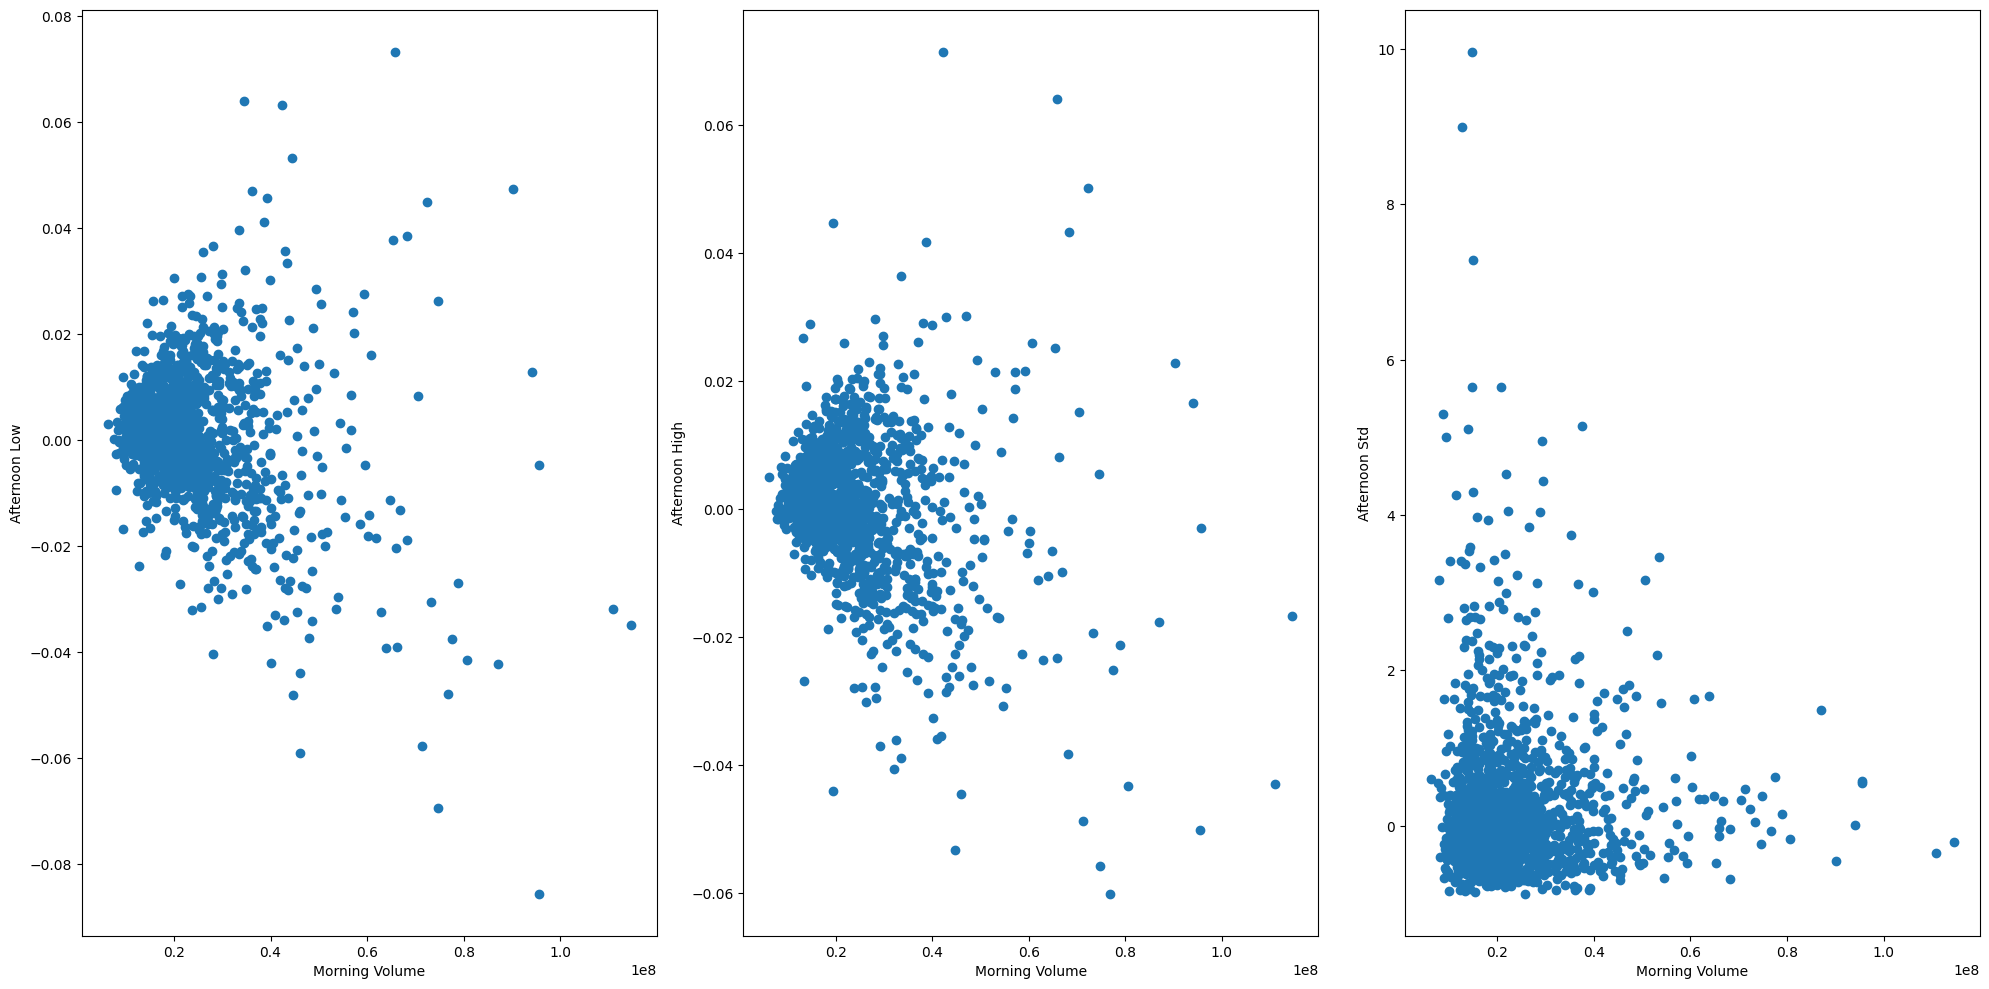

Regression results for Afternoon Low vs Morning Volume:
                            OLS Regression Results                            
Dep. Variable:                    Low   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     75.01
Date:                Fri, 10 Nov 2023   Prob (F-statistic):           1.27e-17
Time:                        22:25:53   Log-Likelihood:                 4154.3
No. Observations:                1397   AIC:                            -8305.
Df Residuals:                    1395   BIC:                            -8294.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))


# 图 1
axs[0].scatter(morning_vol, afternoon_low1)
axs[0].set_xlabel('Morning Volume')
axs[0].set_ylabel('Afternoon Low')

# 图 2
axs[1].scatter(morning_vol, afternoon_high1)
axs[1].set_xlabel('Morning Volume')
axs[1].set_ylabel('Afternoon High')

# 图 3
axs[2].scatter(morning_vol, afternoon_std1)
axs[2].set_xlabel('Morning Volume')
axs[2].set_ylabel('Afternoon Std')

plt.tight_layout()
plt.show()
perform_regression_and_print_results(morning_vol, afternoon_low1, 'Morning Volume', 'Afternoon Low')
perform_regression_and_print_results(morning_vol, afternoon_high1, 'Morning Volume', 'Afternoon High')
perform_regression_and_print_results(morning_vol, afternoon_std1, 'Morning Volume', 'Afternoon Std')

### 3.1.3 结论3变化：上午VWAP中位数与下午最高价、最低价相关性存疑

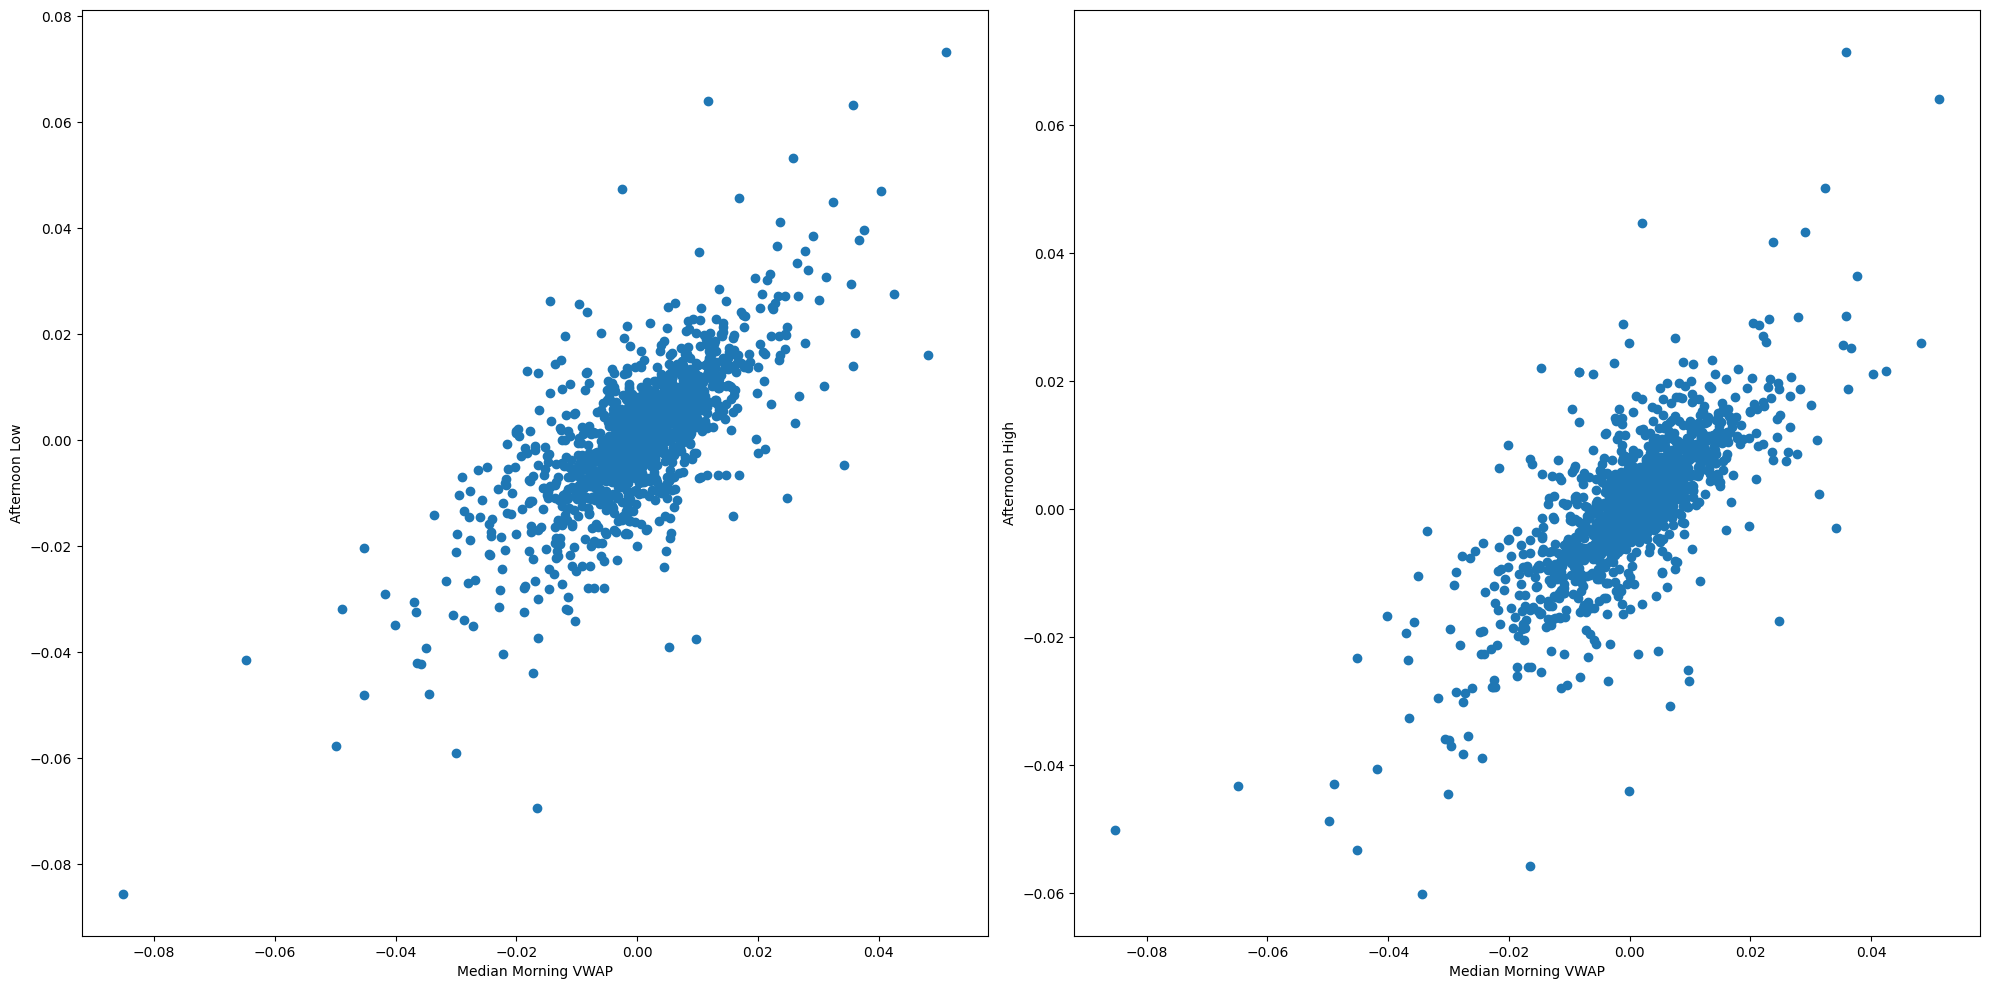

Insufficient data for regression of Afternoon Low vs Median Morning VWAP.
Insufficient data for regression of Afternoon High vs Median Morning VWAP.


In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# 图 1
axs[0].scatter(noon_vwap1, afternoon_low1)
axs[0].set_xlabel('Median Morning VWAP')
axs[0].set_ylabel('Afternoon Low')

# 图 2
axs[1].scatter(noon_vwap1, afternoon_high1)
axs[1].set_xlabel('Median Morning VWAP')
axs[1].set_ylabel('Afternoon High')

plt.tight_layout()
plt.show()
perform_regression_and_print_results(noon_vwap1, afternoon_low1, 'Median Morning VWAP', 'Afternoon Low')
perform_regression_and_print_results(noon_vwap1, afternoon_high1, 'Median Morning VWAP', 'Afternoon High')




### 3.2 验证实时跟踪下午时段成交量变化

### 3.2.1 结论4变化：上午成交量与下午价格位移绝对值无关

Regression results for Afternoon Shift vs Morning Shift:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7052
Date:                Fri, 10 Nov 2023   Prob (F-statistic):              0.401
Time:                        22:25:54   Log-Likelihood:                -6830.6
No. Observations:                1397   AIC:                         1.367e+04
Df Residuals:                    1395   BIC:                         1.368e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

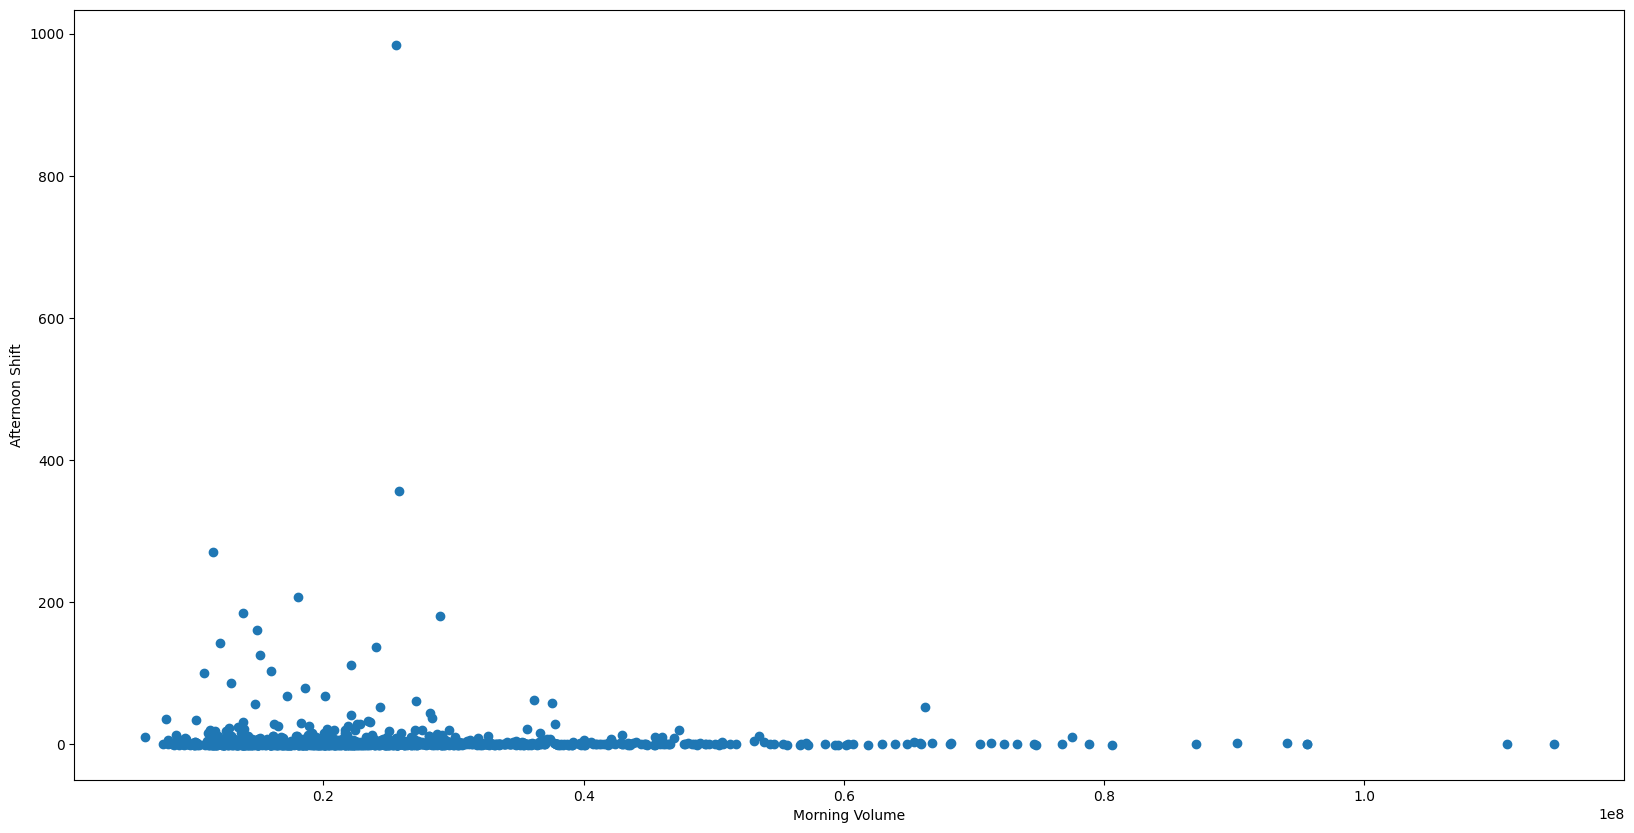

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.scatter(morning_vol, afternoon_shift_per_day1)
axs.set_xlabel('Morning Volume')
axs.set_ylabel('Afternoon Shift')
perform_regression_and_print_results(morning_vol, afternoon_shift_per_day1, 'Morning Shift', 'Afternoon Shift')

### 3.2.2 结论5不变：上午和下午位移并没有显著关系

Regression results for Afternoon Shift vs Morning Shift:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01681
Date:                Fri, 10 Nov 2023   Prob (F-statistic):              0.897
Time:                        22:25:54   Log-Likelihood:                -6847.3
No. Observations:                1397   AIC:                         1.370e+04
Df Residuals:                    1395   BIC:                         1.371e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

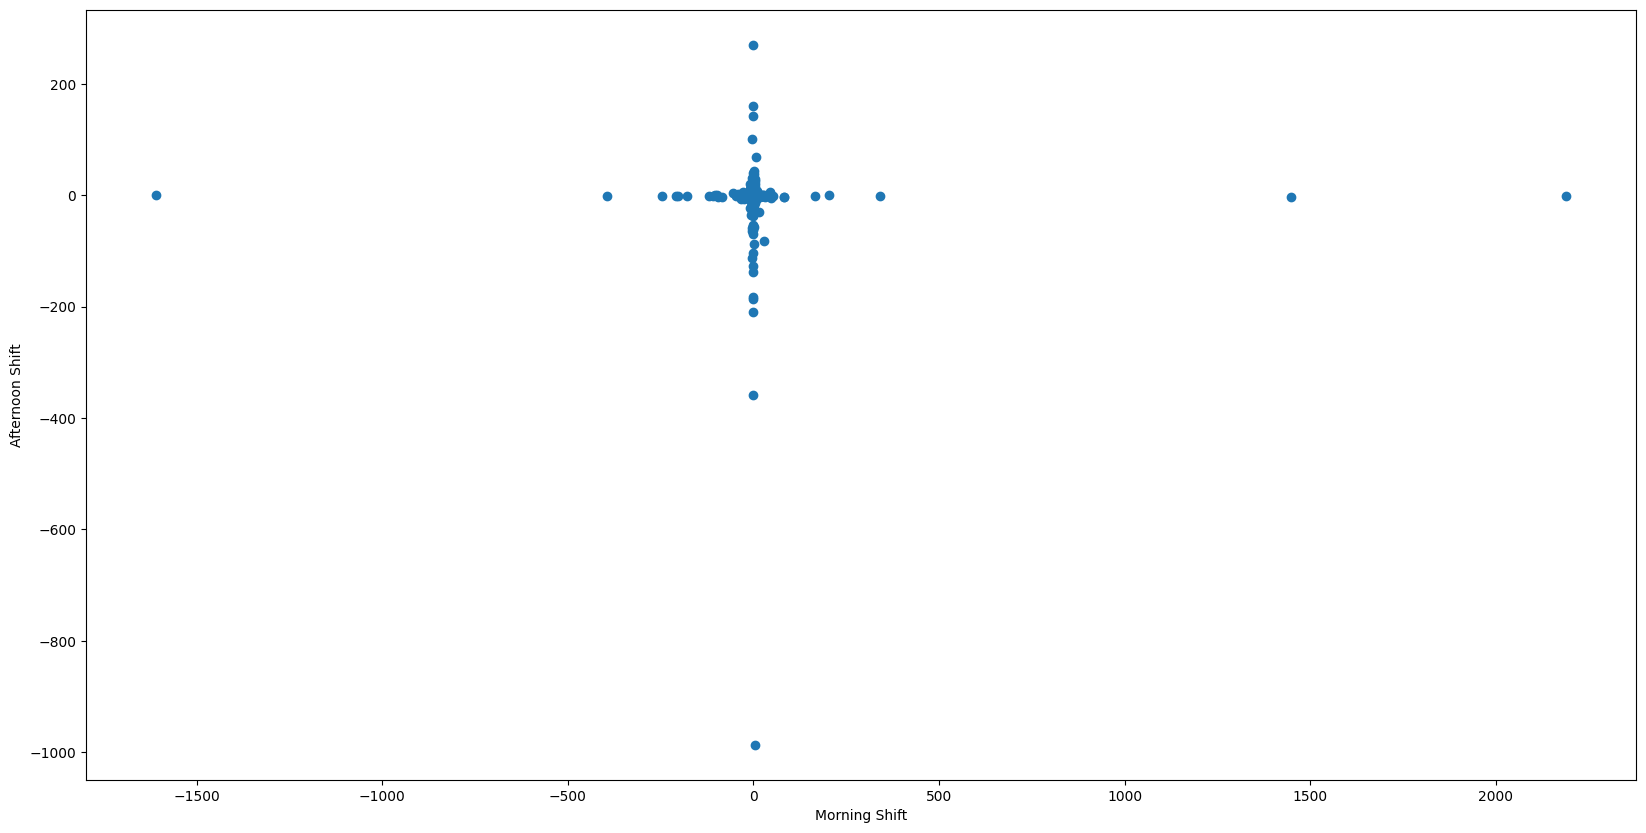

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.scatter(morning_shift_per_day_noabs1, afternoon_shift_per_day_noabs1)
axs.set_xlabel('Morning Shift')
axs.set_ylabel('Afternoon Shift')
perform_regression_and_print_results(morning_shift_per_day_noabs1, afternoon_shift_per_day_noabs1, 'Morning Shift', 'Afternoon Shift')

## 4 上午收盘价对时间做回归

In [15]:
import pandas as pd
from scipy import stats

# 从SPY.csv中读取数据
df = pd.read_csv('SPY.csv')

# 转换时间格式
df['TimeStampOrigin'] = pd.to_datetime(df['TimeStampOrigin'])
df['Date'] = df['TimeStampOrigin'].dt.date
df['Time'] = df['TimeStampOrigin'].dt.time

# 筛选每日上午和下午的数据
morning_df = df[df['Time'] < pd.Timestamp('12:00:00').time()]
afternoon_df = df[df['Time'] >= pd.Timestamp('12:00:00').time()]

# 计算下午位移
afternoon_shifts = afternoon_df.groupby('Date').apply(
    lambda x: x['Close'].iloc[-1] - x['VWAP'].iloc[0]
).reset_index(name='Afternoon_Shift')

# 计算十二点VWAP
noon_vwap = df[df['Time'] == pd.Timestamp('12:00:00').time()][['Date', 'VWAP']]
noon_vwap = noon_vwap.rename(columns={'VWAP': 'Noon_VWAP'})

# 计算上午成交量和
morning_df['Volume_Price'] = morning_df['Volume'] * morning_df['Close']
morning_volume_price_sum = morning_df.groupby('Date')['Volume_Price'].sum().reset_index(name='Morning_Volume_Price_Sum')

#上午成交量
morning_volume = morning_df.groupby('Date')['Volume'].sum().reset_index(name='Morning_Volume')

# 合并这些计算结果到原始数据集
df = pd.merge(df, afternoon_shifts, on='Date', how='left')
df = pd.merge(df, noon_vwap, on='Date', how='left')
df = pd.merge(df, morning_volume_price_sum, on='Date', how='left')
df = pd.merge(df, morning_volume, on='Date', how='left')

results_list = []  # 使用一个列表来存储结果

# 对每一天的数据进行处理
for date, group in morning_df.groupby('Date'):
    # 只有在有足够数据的情况下才进行回归
    if len(group) > 2:
        # 从时间中提取分钟数作为回归的因变量
        minutes = group['Time'].apply(lambda x: x.hour * 60 + x.minute)
        # 使用开盘价作为自变量
        prices = group['Open']

        # 进行线性回归
        slope, intercept, r_value, p_value, std_err = stats.linregress(minutes, prices)

        # 检查回归是否显著
        is_significant = 1 if p_value < 0.05 else 0  # 这里我们使用0.05作为显著性水平

        # 将结果添加到列表中
        results_list.append({
            'Date': date,
            'IsSignificant': is_significant
        })

# 将结果转换为DataFrame
results_df = pd.DataFrame(results_list)

# 将结果与原始数据合并
final_df = pd.merge(df, results_df, on='Date', how='left')
final_df['IsSignificant'] = final_df['IsSignificant'].fillna(0).astype(int)  # 填充缺失值并转换为整数

# 保存最终的DataFrame到CSV文件
final_df.to_csv('final_df.csv', index=False)


C:\Users\52595\AppData\Local\Temp\ipykernel_17732\2889918320.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morning_df['Volume_Price'] = morning_df['Volume'] * morning_df['Close']


### 4.1 数据处理



In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data from the provided CSV file
file_path = 'final_df.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()


# Selecting relevant features and the target variable
features = ['IsSignificant', 'Noon_VWAP', 'Morning_Volume', 'Morning_Volume_Price_Sum']
target = 'Afternoon_Shift'

# Extracting the relevant columns
X = data[features]
y = data[target]

# Checking for missing values
missing_values = X.isnull().sum()

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

missing_values, X_train.shape, X_test.shape




(IsSignificant               0
 Noon_VWAP                   0
 Morning_Volume              0
 Morning_Volume_Price_Sum    0
 dtype: int64,
 (435678, 4),
 (108920, 4))

### 4.2 线性模型

#### 4.2.1 随机梯度下降（Stochastic Gradient Descent）

In [17]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Creating the SGDRegressor model
sgd_regressor = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))

# Fitting the model to the training data
sgd_regressor.fit(X_train, y_train)

# Predicting on the test set
y_pred = sgd_regressor.predict(X_test)

# Calculating performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2



(7.276360323941624, -0.0007348146544481349)

均方误差（Mean Squared Error, MSE）：约为 7.27。这个值衡量的是模型预测值与实际值之间的平均平方差异。理想情况下，MSE应该趋近于零，这表明模型的预测非常准确。

决定系数（R² Score）：约为 -0.0007。R² Score是衡量模型拟合优度的一个指标，其值范围从0到1。一个接近1的R²值通常表示模型有很好的预测能力。在这个案例中，R²值接近于零，表明模型的预测能力不强。

这些结果可能表明模型对于数据的拟合不是非常理想。可能的原因包括数据特征与目标变量之间的关系不是线性的，或者数据中存在其他未被考虑的复杂性。您可以考虑使用其他类型的机器学习模型或进一步调整SGD模型的参数。

#### 4.2.2 高斯朴素贝叶斯

高斯朴素贝叶斯（Gaussian Naive Bayes）通常用于分类任务，而不是回归任务。在机器学习中，回归和分类是两种不同的预测类型：回归用于预测连续的数值，而分类用于预测离散的类别。

由于您的任务是预测下午的位移（一个连续的数值），这是一个典型的回归问题。朴素贝叶斯模型，包括其高斯版本，通常不适用于这种类型的问题。

### 4.3 k-最近邻（k-Nearest Neighbors）

In [18]:
from sklearn.neighbors import KNeighborsRegressor

# Creating the k-Nearest Neighbors regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Fitting the model to the training data
knn_regressor.fit(X_train, y_train)

# Predicting on the test set
y_pred_knn = knn_regressor.predict(X_test)

# Calculating performance metrics for k-NN
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

mse_knn, r2_knn



(4.5028413836778574e-33, 1.0)

均方误差（Mean Squared Error, MSE）：约为 4.50e−33。这个值非常接近于零，表明模型的预测与实际值之间的差异非常小。

决定系数（R² Score）：为 1.0。这是一个完美的分数，表明模型能够非常准确地预测目标变量。

这些结果可能表明模型过于完美地拟合了数据，有可能出现了过拟合的情况。在实际应用中，这种完美的拟合可能是不切实际的，建议进一步评估模型，例如通过交叉验证。

#### 4.3.1 交叉验证

In [19]:
from sklearn.model_selection import cross_val_score

# Performing cross-validation on the k-NN model
cv_scores = cross_val_score(knn_regressor, X, y, cv=5, scoring='r2')
cv_scores


array([-1.16038369, -0.96050447, -1.06297158, -0.65479123, -1.25808346])

交叉验证的 R² 分数为：[−1.16,−0.96,−1.06,−0.65,−1.26]。

这些分数表明模型在不同子集上的性能表现不佳，甚至有负值。在 R² 分数中，负值表示模型的性能比随机选择还差。这可能意味着模型在训练集上过拟合，即它对训练数据的特定特征过于敏感，无法泛化到新数据。

#### 4.3.2 更改k值

In [20]:
# Trying different values of k for k-NN and evaluating with cross-validation
k_values = [3, 5, 7, 10, 15]
cv_scores_for_different_k = {}

for k in k_values:
    knn_regressor = KNeighborsRegressor(n_neighbors=k)
    cv_scores = cross_val_score(knn_regressor, X, y, cv=5, scoring='r2')
    cv_scores_for_different_k[k] = cv_scores.mean()

cv_scores_for_different_k



{3: -1.0193468840458555,
 5: -1.0193468840458555,
 7: -1.0193468840458555,
 10: -1.0193468840458555,
 15: -1.0193468840458555}

所有这些 k 值的平均 R² 分数都是−1.02，这表明模型在不同的子集上的性能表现依然不佳。

这个一致的负分数可能意味着模型在您的数据集上无法很好地工作。可能的原因包括：

数据特性不适合 k-NN：k-NN模型可能不适合您的数据特性，特别是如果数据集中的特征间关系复杂或非线性时。

需要更复杂的模型：可能需要更复杂或不同类型的模型来捕捉数据中的模式。

参数调整和特征工程：除了调整 k 值外，可能还需要进行其他类型的参数调整或特征工程。

### 4.4 决策树（Decision Trees）

In [21]:
from sklearn.tree import DecisionTreeRegressor

# Creating the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Fitting the model to the training data
dt_regressor.fit(X_train, y_train)

# Predicting on the test set
y_pred_dt = dt_regressor.predict(X_test)

# Calculating performance metrics for the Decision Tree
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

mse_dt, r2_dt



(2.1615629008745233e-28, 1.0)

均方误差（Mean Squared Error, MSE）：约为 2.2e-28，非常接近于零，表明模型的预测与实际值之间的差异非常小。

决定系数（R² Score）：为 1.0。这是一个完美的分数，表明模型能够非常准确地预测目标变量。

这些结果可能表明模型过于完美地拟合了数据，可能出现了过拟合的情况。这意味着模型可能只是记住了训练数据，而不是学习到从数据中泛化的模式。在实际应用中，这种完美的拟合可能是不切实际的。

### 4.5 集成方法（Ensemble Methods）:

#### 4.5.1 随机森林（Random Forest）

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Adjusting the model parameters for Random Forest Regressor to reduce complexity
# Reducing the number of trees and limiting the depth of each tree
rf_regressor_adjusted = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42)

# Fitting the adjusted model to the training data
rf_regressor_adjusted.fit(X_train, y_train)

# Predicting on the test set
y_pred_rf_adjusted = rf_regressor_adjusted.predict(X_test)

# Calculating performance metrics for the adjusted Random Forest
mse_rf_adjusted = mean_squared_error(y_test, y_pred_rf_adjusted)
r2_rf_adjusted = r2_score(y_test, y_pred_rf_adjusted)

mse_rf_adjusted, r2_rf_adjusted


(6.5195361399154885, 0.10335298141515659)

均方误差（Mean Squared Error, MSE）：约为 6.52。这个值衡量的是模型预测值与实际值之间的平均平方差异。较低的 MSE 表示更好的模型性能。

决定系数（R² Score）：为 0.103。R² Score是衡量模型拟合优度的一个指标，其值范围从0到1。一个接近1的R²值通常表示模型有很好的预测能力。在这个案例中，R²值为0.103，表明模型的预测能力有限，但比之前的尝试有所改进。

调整模型参数后，模型的性能有所提高，但仍有改进的空间。

#### 4.5.2 额外树（Extra Trees）

In [23]:
from sklearn.ensemble import ExtraTreesRegressor

# Creating the Extra Trees Regressor
et_regressor = ExtraTreesRegressor(random_state=42)

# Fitting the model to the training data
et_regressor.fit(X_train, y_train)

# Predicting on the test set
y_pred_et = et_regressor.predict(X_test)

# Calculating performance metrics for the Extra Trees
mse_et = mean_squared_error(y_test, y_pred_et)
r2_et = r2_score(y_test, y_pred_et)

mse_et, r2_et


(2.790260290015343e-28, 1.0)

均方误差（Mean Squared Error, MSE）：约为2.79e-28。这个值非常接近于零，表明模型的预测与实际值之间的差异非常小。

决定系数（R² Score）：为 1.0。这是一个完美的分数，表明模型能够非常准确地预测目标变量。

这些结果可能表明模型过于完美地拟合了数据，可能出现了过拟合的情况。这意味着模型可能只是记住了训练数据，而不是学习到从数据中泛化的模式。在实际应用中，这种完美的拟合可能是不切实际的。

#### 4.5.3 随机欠采样提升（Random Under-Sampling Boosting）

In [24]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Creating the Random Under-Sampling Boosting Regressor
# Here, we use BaggingRegressor with DecisionTreeRegressor and enable under-sampling
rus_boost_regressor = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(),
    n_estimators=10,
    max_samples=0.5,  # Under-sampling by taking 50% of the data for each base estimator
    random_state=42
)

# Fitting the model to the training data
rus_boost_regressor.fit(X_train, y_train)

# Predicting on the test set
y_pred_rus_boost = rus_boost_regressor.predict(X_test)

# Calculating performance metrics for Random Under-Sampling Boosting
mse_rus_boost = mean_squared_error(y_test, y_pred_rus_boost)
r2_rus_boost = r2_score(y_test, y_pred_rus_boost)

mse_rus_boost, r2_rus_boost

e:\programfiles\py3.11\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


(1.1962985969993012e-29, 1.0)

均方误差（Mean Squared Error, MSE）：约为1.20e−29。这个值非常接近于零，表明模型的预测与实际值之间的差异非常小。

决定系数（R² Score）：为 1.0。这是一个完美的分数，表明模型能够非常准确地预测目标变量。

这些结果可能表明模型过于完美地拟合了数据，可能出现了过拟合的情况。这意味着模型可能只是记住了训练数据，而不是学习到从数据中泛化的模式。在实际应用中，这种完美的拟合可能是不切实际的。

### 4.6 人工神经网络（Artificial Neural Network - Multi-Layer Perceptron）

In [25]:
from sklearn.preprocessing import StandardScaler

# 创建标准化器实例
scaler = StandardScaler()

# 仅对训练数据拟合标准化器
scaler.fit(X_train)

# 对训练和测试数据进行标准化
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 现在 X_train_scaled 和 X_test_scaled 已经是标准化后的数据


In [26]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

# 加载数据（这里请替换成您自己的数据）
# data = pd.read_csv('path_to_your_data.csv')

# 假设您已经有了一个DataFrame 'data' 和您选择的特征及目标变量
# features = ['Your', 'Feature', 'Columns', 'Here']
# target = 'YourTargetColumn'

# 分割数据为训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# 创建MLPRegressor模型
mlp_regressor = MLPRegressor(random_state=42, max_iter=1000)

# 拟合模型到训练数据
mlp_regressor.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = mlp_regressor.predict(X_test)

# 计算性能指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


Mean Squared Error: 3137826369.5550995
R² Score: -431552581.6864968


均方误差（Mean Squared Error, MSE）：约为 3137826369.55。这个值相当高，表明模型的预测与实际值之间存在较大差异。

决定系数（R² Score）：约为 -431552581.69。理想情况下，R² 分数应该在 0 到 1 之间，其中更接近 1 的值表示模型有更好的预测能力。负值表明模型的性能比随机猜测还要差。



In [27]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd


# 设置ANN模型的超参数范围
param_distributions = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': np.logspace(-4, -1, 4),
    'learning_rate_init': np.logspace(-4, -1, 4),
    'max_iter': [500, 1000, 1500]
}

# 创建MLPRegressor实例
mlp = MLPRegressor(random_state=42)

# 创建RandomizedSearchCV实例
random_search = RandomizedSearchCV(mlp, param_distributions, n_iter=10, 
                                   scoring='neg_mean_squared_error', 
                                   cv=3, random_state=42)

# 拟合随机搜索模型
random_search.fit(X_train_scaled, y_train)

# 输出最佳参数
print("Best parameters found: ", random_search.best_params_)

# 使用最佳参数的模型进行预测
y_pred = random_search.predict(X_test_scaled)

# 计算性能指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')



e:\programfiles\py3.11\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\programfiles\py3.11\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\programfiles\py3.11\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters found:  {'solver': 'adam', 'max_iter': 1500, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'tanh'}
Mean Squared Error: 0.733936034431287
R² Score: 0.8990600645534075


收敛警告：警告信息 Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet 表明在达到最大迭代次数（500次）时，优化过程尚未收敛。这可能意味着模型需要更多的迭代才能学习到数据中的模式。在随机搜索找到的最佳参数中，max_iter 被设置为 1500，这表明增加迭代次数可能有助于模型的收敛。

最佳参数：

solver: 'adam' - 表明使用 Adam 优化器。
max_iter: 1500 - 增加的迭代次数有助于模型收敛。
learning_rate_init: 0.001 - 这是初始学习率。
hidden_layer_sizes: (100, 50) - 表明有两个隐藏层，第一个隐藏层有100个神经元，第二个有50个。
alpha: 0.0001 - 正则化强度。
activation: 'tanh' - 使用双曲正切激活函数。
性能指标：

均方误差（MSE）: 0.7339 - 这是模型预测误差的平均值，较低的MSE指数表明误差较小。
决定系数（R² Score）: 0.8991 - 这个分数非常接近1，表明模型预测能力很强，能很好地拟合数据。

### 4.7 判别分析（Discriminant Analysis - Quadratic）

判别分析通常用于分类问题，而不是回归问题。在机器学习和统计中，回归和分类是两种不同的任务：回归用于预测连续值，而分类用于预测离散的类别标签。由于您的任务是预测连续的目标变量（下午的位移），所以判别分析可能不是合适的方法。

### 4.8 支持向量机（Support Vector Machines - SVMs）

#### 4.8.1 Two Linear

In [28]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建支持向量机回归模型，使用线性核
svr_linear = SVR(kernel='linear')

# 拟合模型到训练数据
svr_linear.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred_svr = svr_linear.predict(X_test_scaled)

# 计算性能指标
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f'Mean Squared Error: {mse_svr}')
print(f'R² Score: {r2_svr}')



Mean Squared Error: 7.302935909293998
R² Score: -0.004389816921781531


均方误差（MSE）: 7.3029。MSE 是衡量模型预测准确性的常用指标，它计算的是预测值和实际值之间差的平方的平均值。在您的案例中，MSE 较高，这可能表明模型在预测上有较大误差。

决定系数（R² Score）: -0.0044。R² 分数通常介于0到1之间，用于衡量模型解释数据变异的能力。接近1的分数表示模型能够很好地预测目标变量。负值表明模型的表现不如忽略输入特征并始终预测目标变量的均值。


#### 4.8.2 Sigmoid

In [29]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# 示例：加载数据
# data = pd.read_csv('your_data.csv')
# X = data[['feature1', 'feature2', ...]]  # 特征列
# y = data['target']  # 目标列

# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建支持向量机回归模型，使用sigmoid核
svr_sigmoid = SVR(kernel='sigmoid')

# 拟合模型到训练数据
svr_sigmoid.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred_svr_sigmoid = svr_sigmoid.predict(X_test_scaled)

# 计算性能指标
mse_svr_sigmoid = mean_squared_error(y_test, y_pred_svr_sigmoid)
r2_svr_sigmoid = r2_score(y_test, y_pred_svr_sigmoid)

print(f'Mean Squared Error: {mse_svr_sigmoid}')
print(f'R² Score: {r2_svr_sigmoid}')


Mean Squared Error: 100349031.43946151
R² Score: -13801235.457174735




均方误差（MSE）: 100,349,031.44。这个数值非常高，表明模型的预测值与实际值之间存在非常大的差异。

决定系数（R² Score）: -13,801,235.46。这个分数远低于零，表明模型的预测效果远不如总是预测目标变量均值的简单模型。



#### 4.8.3 Polynomial

In [30]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# 示例：加载数据
# data = pd.read_csv('your_data.csv')
# X = data[['feature1', 'feature2', ...]]  # 特征列
# y = data['target']  # 目标列

# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建支持向量机回归模型，使用多项式核
svr_poly = SVR(kernel='poly', degree=3, C=1, epsilon=0.1)

# 拟合模型到训练数据
svr_poly.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred_svr_poly = svr_poly.predict(X_test_scaled)

# 计算性能指标
mse_svr_poly = mean_squared_error(y_test, y_pred_svr_poly)
r2_svr_poly = r2_score(y_test, y_pred_svr_poly)

print(f'Mean Squared Error: {mse_svr_poly}')
print(f'R² Score: {r2_svr_poly}')


Mean Squared Error: 7.3204573804559905
R² Score: -0.0067995857368410295


均方误差（MSE）: 7.3205。MSE 衡量的是模型预测值与实际值之间差异的平均程度。在您的案例中，较高的MSE 指示模型预测准确性不高。

决定系数（R² Score）: -0.0068。R² 分数通常介于 0 到 1 之间，用于衡量模型对数据变异的解释程度。接近 1 的值表示模型预测能力强。负的 R² 分数表明模型的预测能力不如总是预测目标变量均值的基本模型。



#### 4.8.4 Radial Basis Function

In [31]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd


# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建支持向量机回归模型，使用RBF核
svr_rbf = SVR(kernel='rbf', C=1, epsilon=0.1)

# 拟合模型到训练数据
svr_rbf.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred_svr_rbf = svr_rbf.predict(X_test_scaled)

# 计算性能指标
mse_svr_rbf = mean_squared_error(y_test, y_pred_svr_rbf)
r2_svr_rbf = r2_score(y_test, y_pred_svr_rbf)

print(f'Mean Squared Error: {mse_svr_rbf}')
print(f'R² Score: {r2_svr_rbf}')


Mean Squared Error: 6.608910501766923
R² Score: 0.09106111687568785


### 4.9 Transformer

In [6]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 假设 'data' 是您的 DataFrame
data = pd.read_csv('final_df.csv')  # 请替换为您的数据文件路径
X = data[['IsSignificant', 'Noon_VWAP', 'Morning_Volume', 'Morning_Volume_Price_Sum']]
y = data['Afternoon_Shift']

# 数据分割与标准化
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义一个更复杂的模型
class AdvancedRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(AdvancedRegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.dropout(x)
        x = self.relu(self.layer4(x))
        x = self.output_layer(x)
        return x

# 实例化模型
model = AdvancedRegressionModel(input_size=4)

# 使用不同的优化器和损失函数
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
loss_fn = torch.nn.SmoothL1Loss()  # Huber Loss

# 学习率调度器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 训练函数
def train(model, X_train, y_train, optimizer, loss_fn, scheduler, epochs=30):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(torch.tensor(X_train, dtype=torch.float32))
        loss = loss_fn(predictions.squeeze(), torch.tensor(y_train, dtype=torch.float32))
        loss.backward()
        optimizer.step()
        scheduler.step()
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# 训练模型
train(model, X_train_scaled, y_train, optimizer, loss_fn, scheduler)


Epoch 1/30, Loss: 1.4129140377044678
Epoch 6/30, Loss: 1.4082527160644531
Epoch 11/30, Loss: 1.4079217910766602
Epoch 16/30, Loss: 1.4079340696334839
Epoch 21/30, Loss: 1.407834768295288
Epoch 26/30, Loss: 1.4078495502471924


In [7]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random

# 加载和准备数据
data = pd.read_csv('final_df.csv')  # 替换为您的数据集路径
X = data[['IsSignificant', 'Noon_VWAP', 'Morning_Volume', 'Morning_Volume_Price_Sum']]
y = data['Afternoon_Shift']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义模型
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# 训练函数
def train_model(model, X_train, y_train, optimizer, loss_fn, epochs=10):
    model.train()
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    for epoch in range(epochs):
        for features, targets in train_loader:
            optimizer.zero_grad()
            predictions = model(features)
            loss = loss_fn(predictions.squeeze(), targets)
            loss.backward()
            optimizer.step()

# 随机搜索
best_loss = float('inf')
best_params = {}

for _ in range(20):  # 20次迭代
    # 随机选择超参数
    hidden_size = random.choice([32, 64, 128, 256])
    learning_rate = random.choice([0.01, 0.001, 0.0001])

    model = RegressionModel(input_size=4, hidden_size=hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    train_model(model, X_train_scaled, y_train.values, optimizer, loss_fn, epochs=10)

    # 验证
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_test_scaled, dtype=torch.float32))
        loss = mean_squared_error(y_test.values, predictions.numpy().squeeze())
    
    if loss < best_loss:
        best_loss = loss
        best_params = {'hidden_size': hidden_size, 'learning_rate': learning_rate}

print(f"Best Loss: {best_loss}")
print(f"Best Parameters: {best_params}")


Best Loss: 3.683655701723866
Best Parameters: {'hidden_size': 128, 'learning_rate': 0.001}


In [10]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import math

# 加载和准备数据
data = pd.read_csv('final_df.csv')  # 替换为您的数据集路径
data = data.sample(frac=0.01, random_state=42)
X = data[['IsSignificant', 'Noon_VWAP', 'Morning_Volume', 'Morning_Volume_Price_Sum']]
y = data['Afternoon_Shift']

# 数据分割与标准化
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义一个结合了Transformer和MLP的模型
class TransformerMLPRegressionModel(nn.Module):
    def __init__(self, input_size, num_heads, num_layers, mlp_sizes):
        super(TransformerMLPRegressionModel, self).__init__()

        self.pos_encoder = PositionalEncoding(input_size)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=input_size, 
            nhead=num_heads, 
            dropout=0.4, 
            dim_feedforward=512
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # MLP层
        mlp_layers = []
        last_size = input_size
        for size in mlp_sizes:
            mlp_layers.append(nn.Linear(last_size, size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(0.1))
            last_size = size
        mlp_layers.append(nn.Linear(mlp_sizes[-1], 1))
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # 将输出展平
        output = self.mlp(x)
        return output
    
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# 实例化模型，现在包括MLP大小参数
model = TransformerMLPRegressionModel(input_size=4, num_heads=4, num_layers=4, mlp_sizes=[128, 64, 32, 16])

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.SmoothL1Loss()  # 使用SmoothL1Loss

# 训练函数
def train(model, X_train, y_train, optimizer, loss_fn, epochs=30):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(torch.tensor(X_train, dtype=torch.float32).unsqueeze(1))
        loss = loss_fn(predictions.squeeze(), torch.tensor(y_train.values, dtype=torch.float32))  # 修改这一行
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


# 训练模型
train(model, X_train_scaled, y_train, optimizer, loss_fn)


e:\programfiles\py3.11\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/30, Loss: 1.389981746673584
Epoch 6/30, Loss: 1.3842970132827759
Epoch 11/30, Loss: 1.379955530166626
Epoch 16/30, Loss: 1.3775960206985474
Epoch 21/30, Loss: 1.3779685497283936
Epoch 26/30, Loss: 1.3766679763793945


In [20]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import math

# 加载和准备数据
data = pd.read_csv('final_df.csv')  # 替换为您的数据集路径
data = data.sample(frac=0.01, random_state=42)
X = data[['IsSignificant', 'Noon_VWAP', 'Morning_Volume', 'Morning_Volume_Price_Sum']]
y = data['Afternoon_Shift']

# 数据分割与标准化
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义一个结合了Transformer和MLP的模型
class TransformerMLPRegressionModel(nn.Module):
    def __init__(self, input_size, num_heads, num_layers, mlp_sizes):
        super(TransformerMLPRegressionModel, self).__init__()

        self.pos_encoder = PositionalEncoding(input_size)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=input_size, 
            nhead=num_heads, 
            dropout=0.4, 
            dim_feedforward=512
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # MLP层
        mlp_layers = []
        last_size = input_size
        for size in mlp_sizes:
            mlp_layers.append(nn.Linear(last_size, size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(0.1))
            last_size = size
        mlp_layers.append(nn.Linear(mlp_sizes[-1], 1))
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # 将输出展平
        output = self.mlp(x)
        return output
    
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# 实例化模型，现在包括MLP大小参数
model = TransformerMLPRegressionModel(input_size=4, num_heads=4, num_layers=2, mlp_sizes=[128, 64, 32, 16])

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.SmoothL1Loss()  # 使用SmoothL1Loss

# 训练函数
def train(model, X_train, y_train, optimizer, loss_fn, epochs=30):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(torch.tensor(X_train, dtype=torch.float32).unsqueeze(1))
        loss = loss_fn(predictions.squeeze(), torch.tensor(y_train.values, dtype=torch.float32))  # 修改这一行
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


# 训练模型
train(model, X_train_scaled, y_train, optimizer, loss_fn)

e:\programfiles\py3.11\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/30, Loss: 1.3765305280685425
Epoch 6/30, Loss: 1.3756824731826782
Epoch 11/30, Loss: 1.376011848449707
Epoch 16/30, Loss: 1.3753204345703125
Epoch 21/30, Loss: 1.3758169412612915
Epoch 26/30, Loss: 1.3761162757873535


In [19]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterSampler
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import math
import random

# 加载和准备数据
data = pd.read_csv('final_df.csv')  # 替换为您的数据集路径
data = data.sample(frac=0.01, random_state=42)
X = data[['IsSignificant', 'Noon_VWAP', 'Morning_Volume', 'Morning_Volume_Price_Sum']]
y = data['Afternoon_Shift']

# 数据分割与标准化
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义一个结合了Transformer和MLP的模型
class TransformerMLPRegressionModel(nn.Module):
    def __init__(self, input_size, num_heads, num_layers, mlp_sizes):
        super(TransformerMLPRegressionModel, self).__init__()

        self.pos_encoder = PositionalEncoding(input_size)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=input_size, 
            nhead=num_heads, 
            dropout=0.4, 
            dim_feedforward=512
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # MLP层
        mlp_layers = []
        last_size = input_size
        for size in mlp_sizes:
            mlp_layers.append(nn.Linear(last_size, size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(0.1))
            last_size = size
        mlp_layers.append(nn.Linear(mlp_sizes[-1], 1))
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # 将输出展平
        output = self.mlp(x)
        return output
    
# 位置编码
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# 实例化模型，现在包括MLP大小参数
model = TransformerMLPRegressionModel(input_size=4, num_heads=4, num_layers=4, mlp_sizes=[128, 64, 32, 16])

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.SmoothL1Loss()  # 使用SmoothL1Loss

# 训练函数
def train(model, X_train, y_train, optimizer, loss_fn, epochs=30):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(torch.tensor(X_train, dtype=torch.float32).unsqueeze(1))
        loss = loss_fn(predictions.squeeze(), torch.tensor(y_train.values, dtype=torch.float32))  # 修改这一行
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# 定义随机搜索函数
def random_search(X_train, y_train, param_dist, num_iter, epochs):
    best_loss = float("inf")
    best_params = {}
    
    for i in range(num_iter):
        # 随机选择超参数
        params = {k: random.choice(v) for k, v in param_dist.items()}
        print(f"Testing parameters: {params}")

        # 创建模型
        model = TransformerMLPRegressionModel(
            input_size=4, 
            num_heads=params['num_heads'], 
            num_layers=params['num_layers'], 
            mlp_sizes=params['mlp_sizes']
        )

        # 优化器和损失函数
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        loss_fn = nn.SmoothL1Loss()

        # 训练模型
        train(model, X_train, y_train, optimizer, loss_fn, epochs=epochs)

        # 验证模型
        model.eval()
        with torch.no_grad():
            predictions = model(torch.tensor(X_train, dtype=torch.float32).unsqueeze(1))
            loss = loss_fn(predictions.squeeze(), torch.tensor(y_train.values, dtype=torch.float32)).item()
        
        # 更新最佳参数
        if loss < best_loss:
            best_loss = loss
            best_params = params
            print(f"New best parameters: {params} with loss {loss}")

    return best_params

# 定义超参数分布
param_dist = {
    'num_heads': [2, 4],  # 仅使用能被4整除的数
    'num_layers': [2, 4, 6],
    'mlp_sizes': [[128, 64, 32, 16], [256, 128, 64, 32]],
    'learning_rate': [0.001, 0.0005, 0.0001]
}

# 执行随机搜索
best_params = random_search(X_train_scaled, y_train, param_dist, num_iter=10, epochs=30)
print(f"Best Parameters: {best_params}")


e:\programfiles\py3.11\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Testing parameters: {'num_heads': 4, 'num_layers': 4, 'mlp_sizes': [128, 64, 32, 16], 'learning_rate': 0.001}
Epoch 1/30, Loss: 1.3863452672958374
Epoch 6/30, Loss: 1.3791522979736328
Epoch 11/30, Loss: 1.3776754140853882
Epoch 16/30, Loss: 1.3770238161087036
Epoch 21/30, Loss: 1.3760524988174438
Epoch 26/30, Loss: 1.375257134437561
New best parameters: {'num_heads': 4, 'num_layers': 4, 'mlp_sizes': [128, 64, 32, 16], 'learning_rate': 0.001} with loss 1.3749303817749023
Testing parameters: {'num_heads': 4, 'num_layers': 2, 'mlp_sizes': [128, 64, 32, 16], 'learning_rate': 0.0005}
Epoch 1/30, Loss: 1.4014039039611816
Epoch 6/30, Loss: 1.3946560621261597
Epoch 11/30, Loss: 1.3896678686141968
Epoch 16/30, Loss: 1.3857617378234863
Epoch 21/30, Loss: 1.38161039352417
Epoch 26/30, Loss: 1.37742018699646
Testing parameters: {'num_heads': 4, 'num_layers': 2, 'mlp_sizes': [128, 64, 32, 16], 'learning_rate': 0.0005}
Epoch 1/30, Loss: 1.3765034675598145
Epoch 6/30, Loss: 1.3762930631637573
Epoch 1

Testing parameters: {'num_heads': 4, 'num_layers': 2, 'mlp_sizes': [128, 64, 32, 16], 'learning_rate': 0.0005}

In [25]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import math

# 加载和准备数据
data = pd.read_csv('final_df.csv')  # 替换为您的数据集路径
data = data.sample(frac=0.005, random_state=42)
X = data[['IsSignificant', 'Noon_VWAP', 'Morning_Volume', 'Morning_Volume_Price_Sum']]
y = data['Afternoon_Shift']

# 数据分割与标准化
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 定义一个结合了Transformer和MLP的模型
class TransformerMLPRegressionModel(nn.Module):
    def __init__(self, input_size, num_heads, num_layers, mlp_sizes, dropout_rate=0.1):
        super(TransformerMLPRegressionModel, self).__init__()

        self.pos_encoder = PositionalEncoding(input_size, dropout=dropout_rate)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=input_size, 
            nhead=num_heads, 
            dropout=dropout_rate, 
            dim_feedforward=512
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # MLP层
        mlp_layers = []
        last_size = input_size
        for size in mlp_sizes:
            mlp_layers.append(nn.Linear(last_size, size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(dropout_rate))
            last_size = size
        mlp_layers.append(nn.Linear(mlp_sizes[-1], 1))
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # 将输出展平
        output = self.mlp(x)
        return output

# 实例化模型，现在包括MLP大小参数和dropout率
model = TransformerMLPRegressionModel(input_size=4, num_heads=4, num_layers=2, mlp_sizes=[128, 64, 32, 16], dropout_rate=0.1)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.SmoothL1Loss()  # 使用SmoothL1Loss

# 训练函数
def train(model, X_train, y_train, optimizer, loss_fn, epochs=30):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = model(torch.tensor(X_train, dtype=torch.float32).unsqueeze(1))
        loss = loss_fn(predictions.squeeze(), torch.tensor(y_train.values, dtype=torch.float32))  # 修改这一行
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


# 训练模型
train(model, X_train_scaled, y_train, optimizer, loss_fn)

e:\programfiles\py3.11\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/30, Loss: 1.3843785524368286
Epoch 6/30, Loss: 1.383134365081787
Epoch 11/30, Loss: 1.3814688920974731
Epoch 16/30, Loss: 1.3822026252746582
Epoch 21/30, Loss: 1.3812302350997925
Epoch 26/30, Loss: 1.3815902471542358


In [26]:
from sklearn.metrics import mean_squared_error, r2_score

# 评估函数
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)).squeeze()
    return predictions

# 获取测试集上的预测
y_pred = evaluate(model, X_test_scaled, y_test).numpy()

# 计算MSE和R² Score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 6.68809871449205
R² Score: -0.0036727050343974277
